# OCR Agent from scratch:

* [Data](./Data-Sources.ipynb)
* [Utilities](./Data-Processing.ipynb)
* [Extract layout features and visual tokens](./Data-Extraction-2.ipynb)
* [Generate training data](./Data-Extraction-3.ipynb)
* [Model architecture](./Model-Training.ipynb)
* Traversal strategies
    * [Layout traversal](./Traversal-Layout.ipynb)
    * [Text aggregation](./Traversal-Text.ipynb)
    * Form extraction and validation
* [Reader Agent](./Agent-LM.ipynb)
* [Leverage synthetic training data](./Data-Gen.ipynb)
* [Optimization for production](./Optimization.ipynb)


### Forms
We indexed forms with the identification code and the list of input-fields identifiers / labels; all without the layout specifics due to the forms may come in various layouts.

Form classification is quite straight forward for out agent: find the identification code (one of known set).
Fields extraction and validation are more challenging: not all the forms have the field identifier, and labels could vary.
* retrieve the list of expected fields from our index
* find the entries in the extracted text-lines by matching labels and using spatial proximity

Some forms could have textual labels which could be match via semantic embeddings. Others have only alphanumeric identifiers - direct match with `levenshtein distance` is appropriate. We have `Qdrant` and `ElasticSearch` to handle both types of queries efficiently.

This notebook focused on the spatial aspect of attribution.

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import patches
from IPython.display import display, clear_output
from pathlib import Path
from sklearn.neighbors import KDTree
from unidecode import unidecode
from time import sleep

In [2]:
from scripts.traversal import *

In [3]:
samples = [str(x)[len('data/images/'):-(len('.png'))] for x in Path('./data/images').glob('*.png')]
len(samples)

8631

In [4]:
source = np.random.choice(samples)

In [5]:
print(source)
image = load_image(source)
#Image.fromarray(image)

cnd-t1273.en-3


### 1. Extract features

In [6]:
tokens, words, lines, boxes, _ = extract_layout(image)

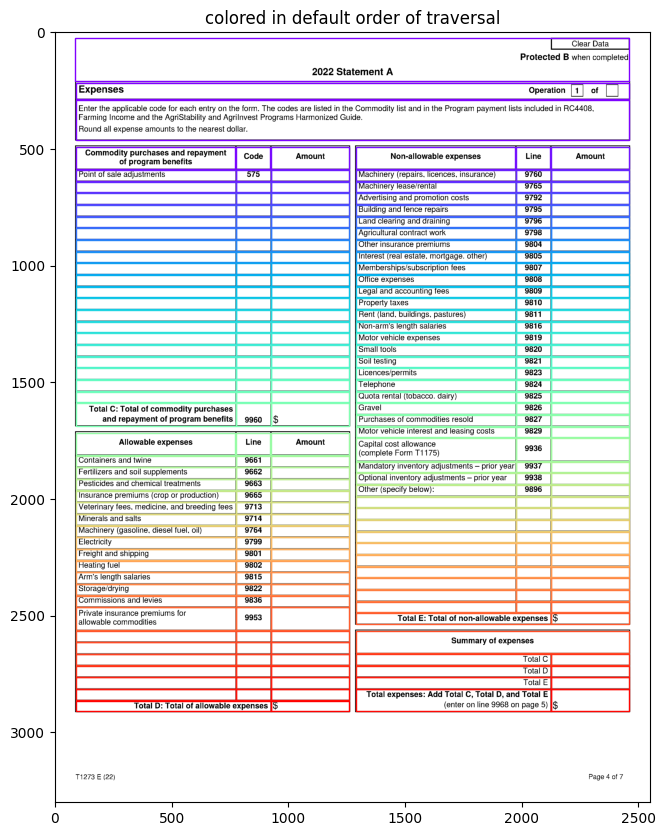

In [7]:
cells = boxes[boxes['type']==CELL]

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image, 'gray')
for i, (x, y, w, h) in enumerate(cells[BOX].values):
    color = plt.cm.rainbow(i/len(cells))
    ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=1, edgecolor=color, facecolor='none'))
plt.title(f'colored in default order of traversal')
plt.show()

### 2. Read content (batch-inference)

In [8]:
reader = get_readers()
Y, P = batch_read(reader, image, tokens)

In [9]:
aggregate_text(tokens, words, lines, proba_threshold=0.)
lines.tail(5)

,left,top,width,height,block-index,text
123,323,2872,601,34,257,Total D: Total of allowable expenses
124,927,2866,43,37,258,$
125,72,3179,199,25,260,T1273 E (22)
126,2272,3179,175,28,261,Page4 of7
127,2444,31,34,37,262,☹


### 3. Identify the form and retrieve the schema

### 4. Match labels and extract the values

In [10]:
form = get_form(source)
for x in form['field_label']:
    if not x.startswith('Cell'):
        print(x)

Operation number 1. Instance 2.
Total operation number. 1 digit. Instance 2.
Line 9960. Total C. Total of commodity purchases and repayment of program benefits.
Total D. Total of allowable expenses.
Non-allowable expenses. Other. Specify.  Row 28. 
Non-allowable expenses. Other. Specify.  Row 29. 
Non-allowable expenses. Other. Specify.  Row 30. 
Non-allowable expenses. Other. Specify.  Row 31. 
Non-allowable expenses. Other. Specify.  Row 32. 
Non-allowable expenses. Other. Specify.  Row 33. 
Non-allowable expenses. Other. Specify.  Row 34. 
Non-allowable expenses. Other. Specify.  Row 35. 
Non-allowable expenses. Other. Specify.  Row 36. 
Non-allowable expenses. Other. Specify.  Row 37.
Total E. Total of non-allowable expenses.
Summary of expenses. Amount from Total C.
Summary of expenses. Amount from Total D.
Summary of expenses. Amount from Total E.
Total expenses. Add amounts from Total C, Total D and Total E. Enter on line 9968 on page 5.


In [11]:
cells = boxes[boxes['type']==CELL]

cells['right'] = cells['left'] + cells['width']
cells['bottom'] = cells['top'] + cells['height']
# find the right factor
prev = None
for f in range(2, 10):
    cells['parent'] = cells.apply(lambda c:(c['left'] >> f, -(c['right'] >> f)), axis=1)
    curr = len(cells.groupby('parent').size())
    if prev and prev == curr: break
    prev = curr

cells['parent'] = cells.apply(lambda c:(c['left']//61, -(c['right']//61)), axis=1)
count = cells.groupby('parent').size().rename('count')
count #.sort_values()

parent
(1, -40)      3
(1, -15)      1
(1, -12)     43
(12, -15)    43
(15, -20)    44
(21, -40)     1
(21, -34)     5
(21, -32)    38
(32, -34)    38
(34, -40)    43
Name: count, dtype: int64

In [12]:
cells = cells.merge(count, on='parent')

In [13]:
cells.sort_values(['parent'])

,left,top,width,height,type,right,bottom,parent,count
0,88,26,2374,184,2,2462,210,"(1, -40)",3
1,90,216,2370,70,2,2460,286,"(1, -40)",3
2,90,290,2370,170,2,2460,460,"(1, -40)",3
258,90,2864,834,46,2,924,2910,"(1, -15)",1
4,90,590,684,46,2,774,636,"(1, -12)",43
...,...,...,...,...,...,...,...,...,...
228,2128,1490,332,46,2,2460,1536,"(34, -40)",43
229,2128,1540,332,46,2,2460,1586,"(34, -40)",43
230,2128,1590,332,46,2,2460,1636,"(34, -40)",43
233,2128,1740,332,96,2,2460,1836,"(34, -40)",43


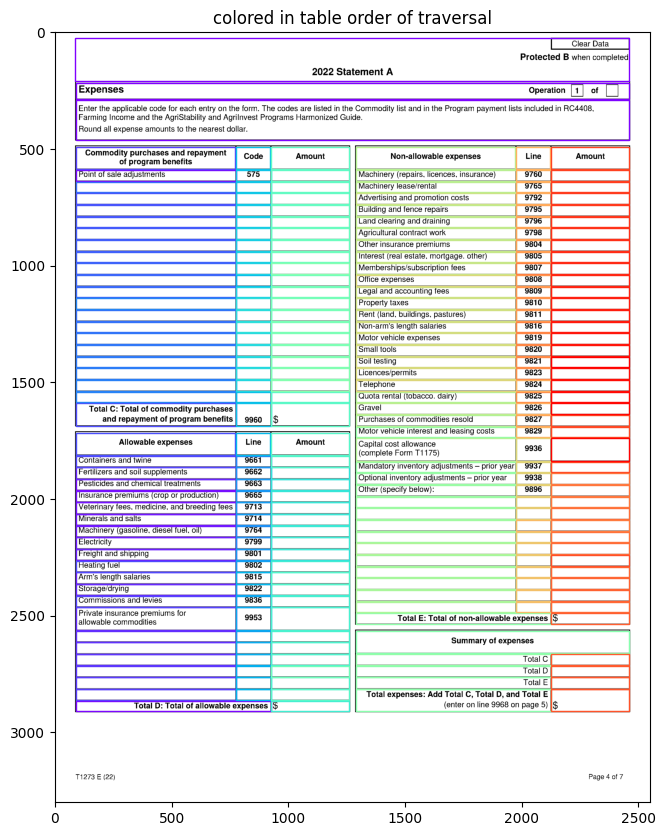

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image, 'gray')
for i, (x, y, w, h) in enumerate(cells.sort_values(['parent'])[BOX].values):
    color = plt.cm.rainbow(i/len(cells))
    ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=1, edgecolor=color, facecolor='none'))
plt.title(f'colored in table order of traversal')
plt.show()

Takeaway: presence of cells simplifies the task, however, relying on spacial proximity only may not be enough for the form validation -- language model would help.